# kaggle study 29일차(New-York taxi)

코드출처 : https://www.kaggle.com/aiswaryaramachandran/eda-baseline-model-0-40-rmse

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
from datetime import datetime
import calendar
from math import sin, cos, sqrt, atan2, radians
from folium import FeatureGroup, LayerControl, Map, Marker
from folium.plugins import HeatMap
import matplotlib.dates as mdates
import matplotlib as mpl
from datetime import timedelta
import datetime as dt
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', -1)
plt.style.use('fivethirtyeight')
import folium
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import pickle

In [5]:
train = pd.read_csv('C:/Users/이동훈/Desktop/github/kaggle/kagglestudy/Data/Newyork/train.csv')
test = pd.read_csv('C:/Users/이동훈/Desktop/github/kaggle/kagglestudy/Data/Newyork/test.csv')
test.shape

(625134, 9)

#### Convert to appropriate datatype
픽업 날짜 시간 및 드롭 다운 날짜 시간을 날짜 시간 개체로 변환합니다.

In [6]:
train['pickup_datetime']=pd.to_datetime(train['pickup_datetime'],format='%Y-%m-%d %H:%M:%S')
train['dropoff_datetime']=pd.to_datetime(train['dropoff_datetime'],format='%Y-%m-%d %H:%M:%S')
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


#### Are there any missing values in the data?

In [7]:
train[pd.isnull(train)].sum()

id                    0.0
vendor_id             0.0
pickup_datetime       0.0
dropoff_datetime      0.0
passenger_count       0.0
pickup_longitude      0.0
pickup_latitude       0.0
dropoff_longitude     0.0
dropoff_latitude      0.0
store_and_fwd_flag    0.0
trip_duration         0.0
dtype: float64

결측치는 없는 것 같다.
#### What is the time period of the dataset?

In [8]:
print('Min pickup time' , min(train['pickup_datetime']))
print('Max pickup time' , max(train['pickup_datetime']))

Min pickup time 2016-01-01 00:00:17
Max pickup time 2016-06-30 23:59:39


이 데이터는 2016년 1월부터 6월까지 6개월 동안의 택시 여행 데이터를 포함합니다.
#### create new day,month, hour info from Pickup time

In [9]:
train['pickup_date']= train['pickup_datetime'].dt.date
train['pickup_day']=train['pickup_datetime'].apply(lambda x:x.day)
train['pickup_hour']=train['pickup_datetime'].apply(lambda x:x.hour)
train['pickup_day_of_week']=train['pickup_datetime'].apply(lambda x:calendar.day_name[x.weekday()])

train['dropoff_date']= train['dropoff_datetime'].dt.date
train['dropoff_day']=train['dropoff_datetime'].apply(lambda x:x.day)
train['dropoff_hour']=train['dropoff_datetime'].apply(lambda x:x.hour)
train['dropoff_day_of_week']=train['dropoff_datetime'].apply(lambda x:calendar.day_name[x.weekday()])

#### Round lat lng to 3 decimal places

In [10]:
train['pickup_latitude_round3']=train['pickup_latitude'].apply(lambda x:round(x,3))
train['pickup_longitude_round3']=train['pickup_longitude'].apply(lambda x:round(x,3))
train['dropoff_latitude_round3']=train['dropoff_latitude'].apply(lambda x:round(x,3))
train['dropoff_longitude_round3']=train['dropoff_longitude'].apply(lambda x:round(x,3))

train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,pickup_hour,pickup_day_of_week,dropoff_date,dropoff_day,dropoff_hour,dropoff_day_of_week,pickup_latitude_round3,pickup_longitude_round3,dropoff_latitude_round3,dropoff_longitude_round3
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,17,Monday,2016-03-14,14,17,Monday,40.768,-73.982,40.766,-73.965
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,0,Sunday,2016-06-12,12,0,Sunday,40.739,-73.980,40.731,-73.999
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,11,Tuesday,2016-01-19,19,12,Tuesday,40.764,-73.979,40.710,-74.005
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,19,Wednesday,2016-04-06,6,19,Wednesday,40.720,-74.010,40.707,-74.012
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,13,Saturday,2016-03-26,26,13,Saturday,40.793,-73.973,40.783,-73.973


#### Based on Latitude and Longitude get the distance of the trip in km
Haversine Distance 사용

In [11]:
def calculateDistance(row):
    R=6373.0 # approximate radius of earth in km
    pickup_lat=radians(row['pickup_latitude'])
    pickup_lon=radians(row['pickup_longitude'])
    dropoff_lat=radians(row['dropoff_latitude'])
    dropoff_lon=radians(row['dropoff_longitude'])
    dlon = dropoff_lon - pickup_lon
    dlat = dropoff_lat - pickup_lat
    a = sin(dlat / 2)**2 + cos(pickup_lat) * cos(dropoff_lat) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    distance = R * c
    return distance

train['trip_distance']=train.apply(lambda row:calculateDistance(row),axis=1)
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,pickup_day_of_week,dropoff_date,dropoff_day,dropoff_hour,dropoff_day_of_week,pickup_latitude_round3,pickup_longitude_round3,dropoff_latitude_round3,dropoff_longitude_round3,trip_distance
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,Monday,2016-03-14,14,17,Monday,40.768,-73.982,40.766,-73.965,1.498991
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,Sunday,2016-06-12,12,0,Sunday,40.739,-73.980,40.731,-73.999,1.806074
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,Tuesday,2016-01-19,19,12,Tuesday,40.764,-73.979,40.710,-74.005,6.387103
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,Wednesday,2016-04-06,6,19,Wednesday,40.720,-74.010,40.707,-74.012,1.485965
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,Saturday,2016-03-26,26,13,Saturday,40.793,-73.973,40.783,-73.973,1.188962


In [12]:
train['trip_duration_in_hour']=train['trip_duration'].apply(lambda x:x/3600)
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,dropoff_date,dropoff_day,dropoff_hour,dropoff_day_of_week,pickup_latitude_round3,pickup_longitude_round3,dropoff_latitude_round3,dropoff_longitude_round3,trip_distance,trip_duration_in_hour
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,2016-03-14,14,17,Monday,40.768,-73.982,40.766,-73.965,1.498991,0.126389
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,2016-06-12,12,0,Sunday,40.739,-73.980,40.731,-73.999,1.806074,0.184167
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,2016-01-19,19,12,Tuesday,40.764,-73.979,40.710,-74.005,6.387103,0.590000
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,2016-04-06,6,19,Wednesday,40.720,-74.010,40.707,-74.012,1.485965,0.119167
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,2016-03-26,26,13,Saturday,40.793,-73.973,40.783,-73.973,1.188962,0.120833


#### Exploratory Analysis

Text(0.5, 0, 'Trip Duration (in hour)')

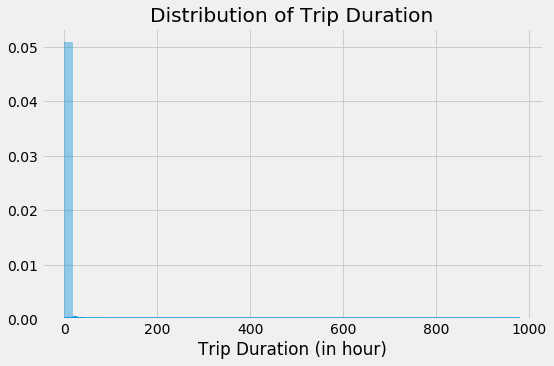

In [13]:
plt.figure(figsize=(8,5))
sns.distplot(train['trip_duration_in_hour']).set_title("Distribution of Trip Duration")
plt.xlabel("Trip Duration (in hour)")

24시간보다 긴 주행 시간이 있습니다. 이걸 조사해야 할까요?

In [14]:
outlier_trip_duration = train.loc[train['trip_duration_in_hour']>24]
outlier_trip_duration

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,dropoff_date,dropoff_day,dropoff_hour,dropoff_day_of_week,pickup_latitude_round3,pickup_longitude_round3,dropoff_latitude_round3,dropoff_longitude_round3,trip_distance,trip_duration_in_hour
355003,id1864733,1,2016-01-05 00:19:42,2016-01-27 11:08:38,1,-73.789650,40.643559,-73.956810,40.773087,N,...,2016-01-27,27,11,Wednesday,40.644,-73.790,40.773,-73.957,20.154989,538.815556
680594,id0369307,1,2016-02-13 22:38:00,2016-03-08 15:57:38,2,-73.921677,40.735252,-73.984749,40.759979,N,...,2016-03-08,8,15,Tuesday,40.735,-73.922,40.760,-73.985,5.984365,569.327222
924150,id1325766,1,2016-01-05 06:14:15,2016-01-31 01:01:07,1,-73.983788,40.742325,-73.985489,40.727676,N,...,2016-01-31,31,1,Sunday,40.742,-73.984,40.728,-73.985,1.635641,618.781111
978383,id0053347,1,2016-02-13 22:46:52,2016-03-25 18:18:14,1,-73.783905,40.648632,-73.978271,40.750202,N,...,2016-03-25,25,18,Friday,40.649,-73.784,40.750,-73.978,19.906909,979.522778


24시간보다 긴 주행 시간이 있습니다. 우리는 이것을 조사해야 할 것입니다.

In [15]:
outlier_trip_duration = train.loc[train['trip_duration_in_hour']>24]
outlier_trip_duration

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,dropoff_date,dropoff_day,dropoff_hour,dropoff_day_of_week,pickup_latitude_round3,pickup_longitude_round3,dropoff_latitude_round3,dropoff_longitude_round3,trip_distance,trip_duration_in_hour
355003,id1864733,1,2016-01-05 00:19:42,2016-01-27 11:08:38,1,-73.789650,40.643559,-73.956810,40.773087,N,...,2016-01-27,27,11,Wednesday,40.644,-73.790,40.773,-73.957,20.154989,538.815556
680594,id0369307,1,2016-02-13 22:38:00,2016-03-08 15:57:38,2,-73.921677,40.735252,-73.984749,40.759979,N,...,2016-03-08,8,15,Tuesday,40.735,-73.922,40.760,-73.985,5.984365,569.327222
924150,id1325766,1,2016-01-05 06:14:15,2016-01-31 01:01:07,1,-73.983788,40.742325,-73.985489,40.727676,N,...,2016-01-31,31,1,Sunday,40.742,-73.984,40.728,-73.985,1.635641,618.781111
978383,id0053347,1,2016-02-13 22:46:52,2016-03-25 18:18:14,1,-73.783905,40.648632,-73.978271,40.750202,N,...,2016-03-25,25,18,Friday,40.649,-73.784,40.750,-73.978,19.906909,979.522778


4개의 기록이 있어 주행 지속 시간은 매우 높지만 주행 거리는 매우 낮습니다. 특이치입니다. 하지만 이 여행이 시작되거나 끝나는 특별한 장소가 있나요? 트립 지속시간도 왜곡되어 있으므로 로그 변환을 살펴보겠습니다.

이러한 데이터는 테스트 데이터의 일부일 수 있으므로 분석에서 제거되지 않습니다.

Text(0.5, 0, 'Distribution of trip duration(sec)in Log Scale')

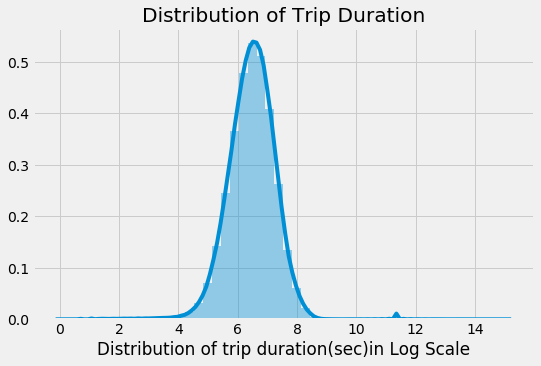

In [16]:
plt.figure(figsize=(8,5))
sns.distplot(np.log(train['trip_duration'].values)).set_title("Distribution of Trip Duration")
plt.xlabel("Distribution of trip duration(sec)in Log Scale")

트립 지속 시간의 로그 변환은 정규 분포를 따릅니다. 대부분의 트립은 54초(exp(4)에서 2980초(exp(8) 사이입니다. 이것은 대부분의 여행이 1시간 이내임을 나타냅니다. 하지만, 1분도 채 안 되는 여행도 있고 자세히 알아봐야 합니다. 100시간 동안 지속되는 여행들이 있는데 택시들이 뉴욕안에 있기 때문에 이상합니다.

#### Heatmap of common locations from where pickup and dropoff occurs

In [17]:
pickup = train.groupby(['pickup_latitude_round3','pickup_longitude_round3'])['id'].count().reset_index().rename(columns={'id':'Num_Trips'})

In [23]:
pickup_map = folium.Map(location = [40.730610,-73.935242],zoom_start = 10,)
#print(pickup.shape)
'''
for index, row in pickup.iterrows():
    
    folium.CircleMarker([row['pickup_latitude_round3'], row['pickup_longitude_round3']],
                        radius=3,
                        
                        fill_color="#3db7e4", 
                        fill_opacity=0.9
                       ).add_to(pickup_map)
    count=count + 1


'''
hm_wide = HeatMap( list(zip(pickup.pickup_latitude_round3.values, pickup.pickup_longitude_round3.values, np.array(pickup.Num_Trips.values).astype('float64'))),
                     min_opacity=0.2,radius=5, blur=15,max_zoom=1)
pickup_map.add_child(hm_wide)

pickup_map

(-74.03, -73.75)

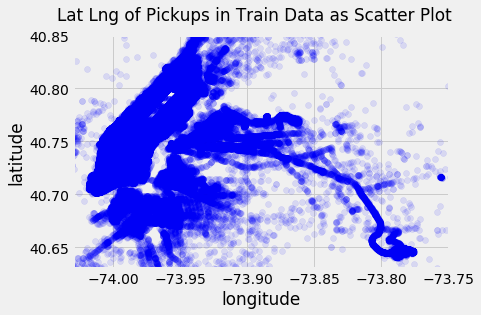

In [20]:
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)
fig, ax = plt.subplots(ncols=1, sharex=True, sharey=True)
ax.scatter(train['pickup_longitude'], train['pickup_latitude'],
              color='blue', label='train', alpha=0.1)

fig.suptitle('Lat Lng of Pickups in Train Data as Scatter Plot')

ax.set_ylabel('latitude')
ax.set_xlabel('longitude')
plt.ylim(city_lat_border)
plt.xlim(city_long_border)

#### This graph clearly shows heavy density of pickups near JFK

In [21]:
drop=train.groupby(['dropoff_latitude_round3','dropoff_longitude_round3'])['id'].count().reset_index().rename(columns={'id':'Num_Trips'})

In [25]:
drop_map = folium.Map(location = [40.730610,-73.935242],zoom_start = 10,)
#print(pickup.shape)
'''
for index, row in drop.iterrows():
    folium.CircleMarker([row['dropoff_latitude_round3'], row['dropoff_longitude_round3']],
                        radius=3,color="#008000", fill_opacity=0.9).add_to(drop_map)
    count=count + 1

'''
hm_wide = HeatMap( list(zip(drop.dropoff_latitude_round3.values, drop.dropoff_longitude_round3.values, np.array(drop.Num_Trips.values).astype('float64'))),
                  min_opacity=0.2,radius=5, blur=15,max_zoom=1)
drop_map.add_child(hm_wide)

drop_map

dropoff 히트맵은 pickup과 유사합니다.
#### heatmap of trip duration, when pickup originates from a point

In [26]:
pickup = train.groupby(['pickup_latitude_round3','pickup_longitude_round3'])['trip_duration'].mean().reset_index().rename(columns={'trip_duration':'Avg_Trip_duration'})

In [28]:
pickup_map = folium.Map(location = [40.730610,-73.935242],zoom_start = 10,)


hm_wide = HeatMap( list(zip(pickup.pickup_latitude_round3.values, pickup.pickup_longitude_round3.values, pickup.Avg_Trip_duration.values)),
                  min_opacity=0.2,radius=7, blur=15,max_zoom=1)
pickup_map.add_child(hm_wide)
pickup_map

평균 주행 지속 시간은 JFK에서 출발한 경우 더 높습니다. 확대해보면 맨하탄 이후 JFK의 픽업 차량이 더 오래 걸리는 것을 알 수 있습니다.
#### Which hours are pickup and dropoff higher?

Text(0.5, 1.0, 'Pickup Hours Distribution')

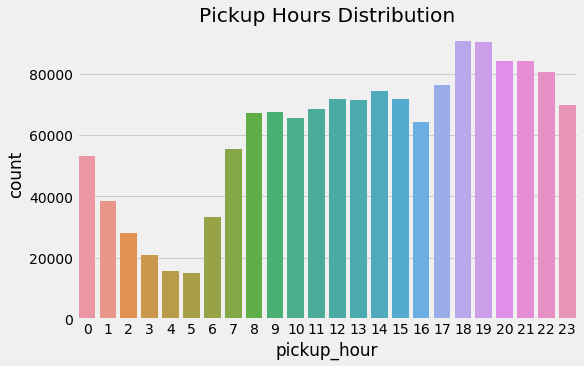

In [31]:
plt.figure(figsize=(8,5))
sns.countplot(x=train['pickup_hour']).set_title('Pickup Hours Distribution')

이른 아침에는 픽업이 훨씬 더 낮습니다. 대부분의 피클립은 오후 6시에서 8시 사이에 가장 높습니다.

Text(0.5, 1.0, 'Dropoff Hours Distribution')

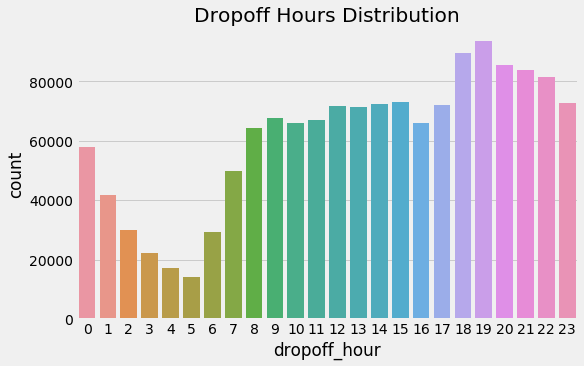

In [32]:
plt.figure(figsize=(8,5))
sns.countplot(x=train['dropoff_hour']).set_title('Dropoff Hours Distribution')

dropoff 시간은 pickup 시간과 매우 유사합니다.
#### Pickups over the entire time period

Text(0.5, 1.0, 'Distribution of Pickups over time')

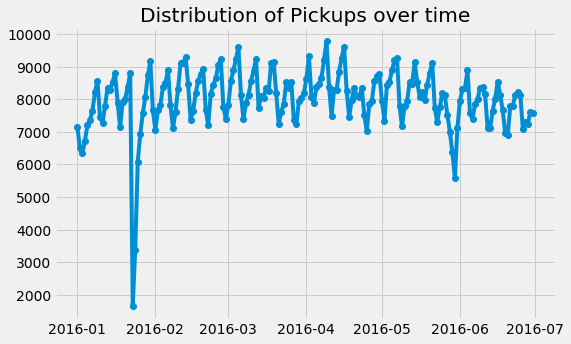

In [34]:
plt.figure(figsize=(8,5))
plt.plot(train.groupby('pickup_date').count()[['id']], 'o-',label='train')
plt.title("Distribution of Pickups over time")

2016년 1월 말 픽업 건수가 감소했습니다.

#### What is the distribution of Trip distance

[0.40479235 0.59115541 1.85428079 ... 2.05758723 0.088841   0.12610208]


Text(0.5, 0, 'Trip Distance (log)')

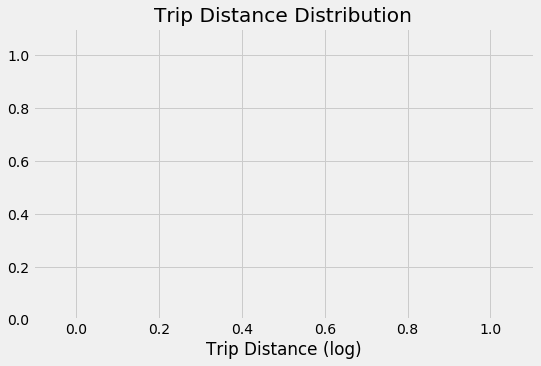

In [39]:
print(np.log(train['trip_distance'].values))
plt.figure(figsize=(8,5))
sns.kdeplot(np.log(train['trip_distance'].values)).set_title("Trip Distance Distribution")
plt.xlabel("Trip Distance (log)")

#### Trip Duration vs Trip Distance

Text(0, 0.5, 'Trip Duration (log scale)')

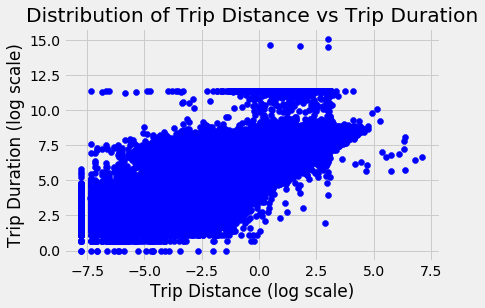

In [40]:
plt.scatter(np.log(train['trip_distance'].values), np.log(train['trip_duration'].values),
              color='blue', label='train')
plt.title("Distribution of Trip Distance vs Trip Duration")
plt.xlabel("Trip Distance (log scale)")
plt.ylabel("Trip Duration (log scale)")

#### Is the trip duration higher at different hours?

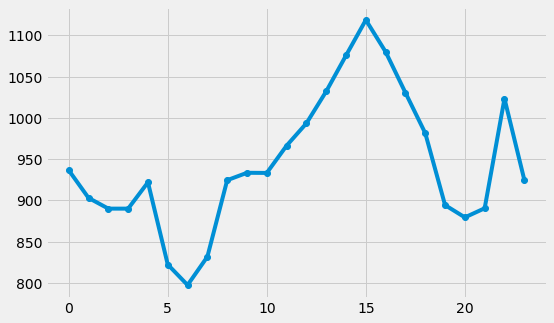

In [41]:
avg_duration_hour=train.groupby(['pickup_hour'])['trip_duration'].mean().reset_index().rename(columns={'trip_duration':'avg_trip_duration'})
plt.figure(figsize=(8,5))
plt.plot(train.groupby(['pickup_hour'])['trip_duration'].mean(),'o-')

트립 지속시간이 10~15시간 증가합니다.
#### Distribution of Pickups across Days

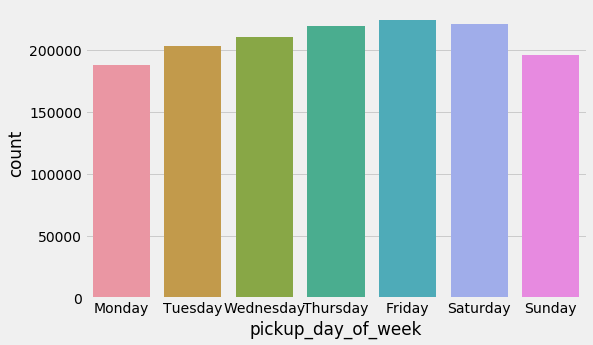

In [42]:
plt.figure(figsize=(8,5))
sns.countplot(train['pickup_day_of_week'],order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday'])

월요일에 픽업 건수가 매우 적습니다.화요일부터 금요일까지 픽업의 수가 계속 증가하고 있습니다.

#### Avg Trip Duration over Days of week

Text(0.5, 1.0, 'Avg Trip Duration vs Pickup Days of Week')

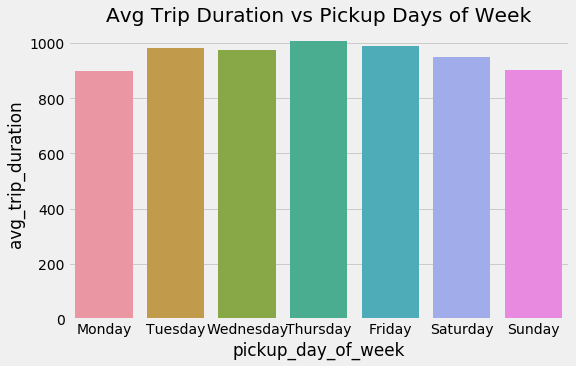

In [43]:
avg_duration_day=train.groupby(['pickup_day_of_week'])['trip_duration'].mean().reset_index().rename(columns={'trip_duration':'avg_trip_duration'})

plt.figure(figsize=(8,5))
sns.barplot(x='pickup_day_of_week',y='avg_trip_duration',data=avg_duration_day,order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday']).set_title("Avg Trip Duration vs Pickup Days of Week")

평균 최고 속도는 목요일입니다.

#### Create a caluclated field Bearing
베어링은 이동방향을 측정합니다. 공식은 
$θ = atan2( sin Δλ ⋅ cos φ2 , cos φ1 ⋅ sin φ2 − sin φ1 ⋅ cos φ2 ⋅ cos Δλ ) $λ 는 경도입니다.

In [44]:
def calculateBearing(lat1,lng1,lat2,lng2):
    R = 6371 
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

train['bearing']=train.apply(lambda row:calculateBearing(row['pickup_latitude_round3'],row['pickup_longitude_round3'],row['dropoff_latitude_round3'],row['dropoff_longitude_round3']),axis=1)

#### Distribution of Bearing

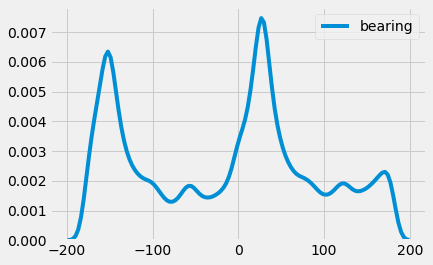

In [45]:
sns.kdeplot(train['bearing'])

#### Bearing vs Trip Duration

Text(0, 0.5, 'Trip Duration (log scale)')

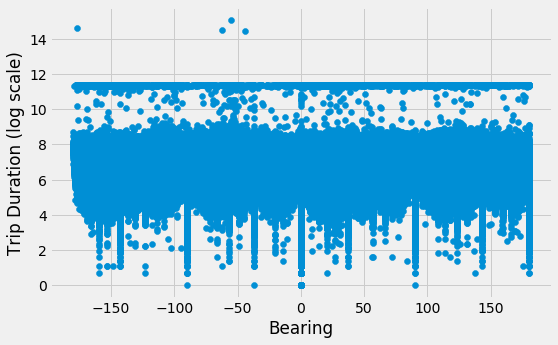

In [46]:
plt.figure(figsize=(8,5))
plt.scatter(train['bearing'].values,y=np.log(train['trip_duration'].values))
plt.xlabel("Bearing")
plt.ylabel("Trip Duration (log scale)")

트립 지속 시간의 특이치는 모두 베어링 -50도 주위에 있습니다.
#### Distribution of Store and FWD Flag

In [47]:
train['store_and_fwd_flag'].value_counts()

N    1450599
Y    8045   
Name: store_and_fwd_flag, dtype: int64

Text(0, 0.5, 'Density')

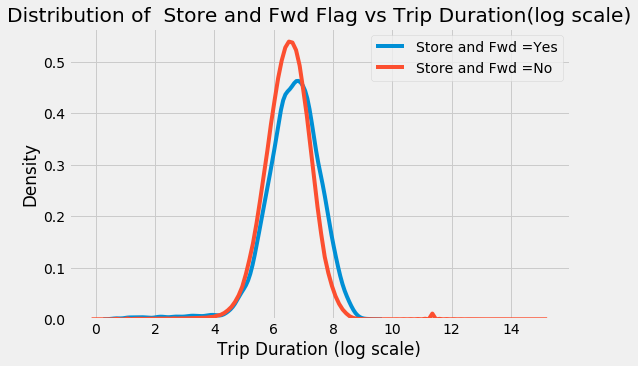

In [48]:
plt.figure(figsize=(8,5))
sns.kdeplot(np.log(train.loc[train['store_and_fwd_flag']=='Y','trip_duration'].values),label= 'Store and Fwd =Yes')
sns.kdeplot(np.log(train.loc[train['store_and_fwd_flag']=='N','trip_duration'].values),label= 'Store and Fwd =No')
   
plt.title("Distribution of  Store and Fwd Flag vs Trip Duration(log scale)")
plt.xlabel('Trip Duration (log scale)')
plt.ylabel('Density')

#### Group Locations into cluster
이것은 이웃을 만드는 데 도움이 될 것입니다. 그리고 어떤 동네에서 픽업하는 것이 더 긴 여행 기간을 가질 수 있습니다.

(-74.03, -73.75)

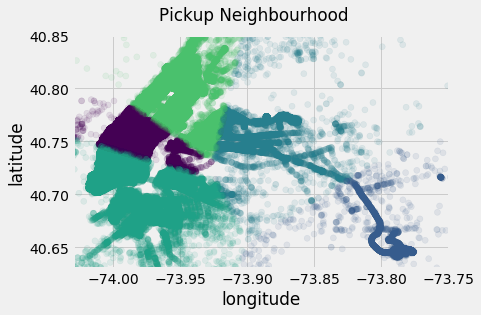

In [49]:
coords = np.vstack((train[['pickup_latitude', 'pickup_longitude']].values,
                    train[['dropoff_latitude', 'dropoff_longitude']].values,
                    test[['pickup_latitude', 'pickup_longitude']].values,
                    test[['dropoff_latitude', 'dropoff_longitude']].values))
kmeans = KMeans(n_clusters=8, random_state=0).fit(coords)
train.loc[:, 'pickup_neighbourhood'] = kmeans.predict(train[['pickup_latitude', 'pickup_longitude']])
train.loc[:, 'dropoff_neighbourhood'] = kmeans.predict(train[['dropoff_latitude', 'dropoff_longitude']])
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)
fig, ax = plt.subplots(ncols=1, sharex=True, sharey=True)
ax.scatter(train['pickup_longitude'], train['pickup_latitude'],
              c=train['pickup_neighbourhood'], label='train', alpha=0.1)

fig.suptitle('Pickup Neighbourhood')

ax.set_ylabel('latitude')
ax.set_xlabel('longitude')
plt.ylim(city_lat_border)
plt.xlim(city_long_border)

#### Number of pickups in each neighbourhood

Text(0.5, 1.0, 'Distribution of Number of Pickups across Neighbourhoods')

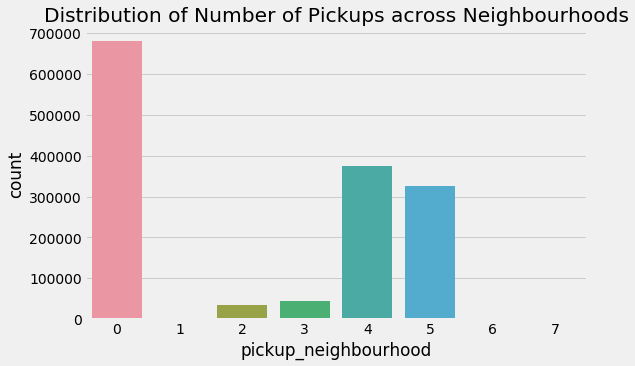

In [50]:
plt.figure(figsize=(8,5))
sns.countplot(train['pickup_neighbourhood']).set_title("Distribution of Number of Pickups across Neighbourhoods")

Text(0.5, 1.0, 'Avg Trip Duration vs Neighbourhood')

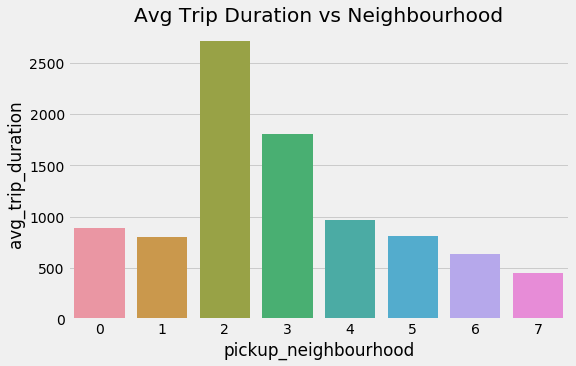

In [51]:
avg_duration_neighbourhood=train.groupby(['pickup_neighbourhood'])['trip_duration'].mean().reset_index().rename(columns={'trip_duration':'avg_trip_duration'})
plt.figure(figsize=(8,5))
sns.barplot(x='pickup_neighbourhood',y='avg_trip_duration',data=avg_duration_neighbourhood).set_title("Avg Trip Duration vs Neighbourhood")

Neighborhood 2는 평균 주행 시간이 매우 높지만, Neighborhood 0은 픽업의 대부분을 차지합니다.
#### Distribution of Average speed

Text(0.5, 1.0, 'Distribution of Average Speed (in kph)')

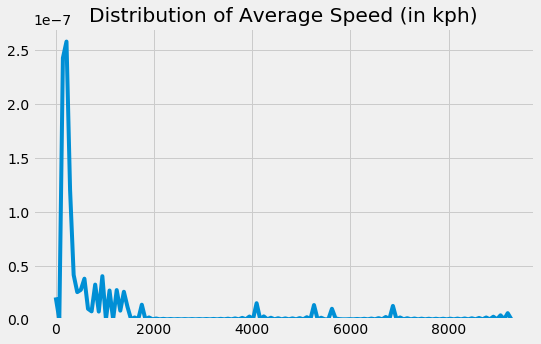

In [52]:
train['avg_speed_kph']=train['trip_distance']/train['trip_duration_in_hour']
plt.figure(figsize=(8,5))
sns.kdeplot(train['avg_speed_kph'].values).set_title("Distribution of Average Speed (in kph)")

In [53]:
print("Average speed is",np.mean(train['avg_speed_kph']),"kph") #The average speed is 14 kmph

Average speed is 14.427736738458588 kph


Text(0.5, 1.0, 'Avg Speed (kph) vs Pickup Days of Week')

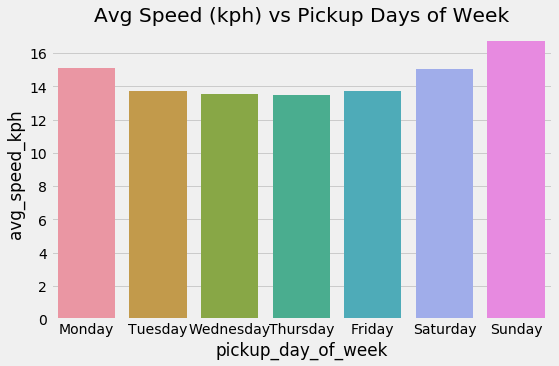

In [54]:
avg_speed_per_day=train.groupby(['pickup_day_of_week'])['avg_speed_kph'].mean().reset_index()
plt.figure(figsize=(8,5))
sns.barplot(x='pickup_day_of_week',y='avg_speed_kph',data=avg_speed_per_day,order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday']).set_title("Avg Speed (kph) vs Pickup Days of Week")

평균 속도는 일요일과 월요일이 더 높습니다.
#### Feature Engineering on Test Data

In [55]:
test['pickup_datetime']=pd.to_datetime(test['pickup_datetime'],format='%Y-%m-%d %H:%M:%S')
#test['dropoff_datetime']=pd.to_datetime(test['dropoff_datetime'],format='%Y-%m-%d %H:%M:%S')

test['pickup_date']= test['pickup_datetime'].dt.date
test['pickup_day']=test['pickup_datetime'].apply(lambda x:x.day)
test['pickup_hour']=test['pickup_datetime'].apply(lambda x:x.hour)
test['pickup_day_of_week']=test['pickup_datetime'].apply(lambda x:calendar.day_name[x.weekday()])
#test['dropoff_date']= test['dropoff_datetime'].dt.date
#test['dropoff_day']=test['dropoff_datetime'].apply(lambda x:x.day)
#test['dropoff_hour']=test['dropoff_datetime'].apply(lambda x:x.hour)
#test['dropoff_day_of_week']=test['dropoff_datetime'].apply(lambda x:calendar.day_name[x.weekday()])

test['pickup_latitude_round3']=test['pickup_latitude'].apply(lambda x:round(x,3))
test['pickup_longitude_round3']=test['pickup_longitude'].apply(lambda x:round(x,3))
test['dropoff_latitude_round3']=test['dropoff_latitude'].apply(lambda x:round(x,3))
test['dropoff_longitude_round3']=test['dropoff_longitude'].apply(lambda x:round(x,3))
test['trip_distance']=test.apply(lambda row:calculateDistance(row),axis=1)
#test['trip_duration_in_hour']=test['trip_duration'].apply(lambda x:x/3600)

test['bearing']=test.apply(lambda row:calculateBearing(row['pickup_latitude_round3'],row['pickup_longitude_round3'],row['dropoff_latitude_round3'],row['dropoff_longitude_round3']),axis=1)
test.loc[:, 'pickup_neighbourhood'] = kmeans.predict(test[['pickup_latitude', 'pickup_longitude']])
test.loc[:, 'dropoff_neighbourhood'] = kmeans.predict(test[['dropoff_latitude', 'dropoff_longitude']])

#### Building Models
교육 데이터에서 "drop off date time features" 기능을 삭제해야 합니다. 또한 선반은 소수점 3자리까지만 반올림해 둡니다.

In [57]:
drop_cols=['avg_speed_kph','trip_duration_in_hour','dropoff_date','dropoff_day','dropoff_hour','dropoff_day_of_week','dropoff_datetime','pickup_latitude','pickup_longitude','dropoff_latitude','dropoff_longitude']
training=train.drop(drop_cols,axis=1)
testing=test.drop(['pickup_latitude','pickup_longitude','dropoff_latitude','dropoff_longitude'],axis=1)

우리는 trip_duration을 예측해야 합니다. 이를 로그 척도로 변환하여 예측합니다.

In [58]:
training['log_trip_duration']=training['trip_duration'].apply(lambda x:np.log(x))
training.drop(['trip_duration'],axis=1,inplace=True)

print("Training Data Shape ",training.shape)
print("Testing Data Shape ",testing.shape)

Training Data Shape  (1458644, 18)
Testing Data Shape  (625134, 17)


요일을 숫자로 인코딩해 보겠습니다.

In [59]:
def encodeDays(day_of_week):
    day_dict={'Sunday':0,'Monday':1,'Tuesday':2,'Wednesday':3,'Thursday':4,'Friday':5,'Saturday':6}
    return day_dict[day_of_week]

training['pickup_day_of_week']=training['pickup_day_of_week'].apply(lambda x:encodeDays(x))
testing['pickup_day_of_week']=testing['pickup_day_of_week'].apply(lambda x:encodeDays(x))

In [60]:
training.to_csv("input_training.csv",index=False)
testing.to_csv("input_testing.csv",index=False)
del training
del testing
del train
del test

In [61]:
def LabelEncoding(train_df,test_df,max_levels=2):
    for col in train_df:
        if train_df[col].dtype == 'object':
            if len(list(train_df[col].unique())) <= max_levels:
                le = preprocessing.LabelEncoder()
                le.fit(train_df[col])
                train_df[col]=le.transform(train_df[col])
                test_df[col]=le.transform(test_df[col])
    return [train_df,test_df]
                

def readInputAndEncode(input_path,train_file,test_file,target_column):
    training=pd.read_csv(input_path+train_file)
    testing=pd.read_csv(input_path+test_file)
   
    training,testing=LabelEncoding(training,testing)
    
    #print("Training Data Shape after Encoding ",training.shape)
    #print("Testing Data Shape after Encoding ",testing.shape)
    #테스트 데이터에 모든 열차 열이 있는지 확인합니다. 검정 데이터에 열을 추가하지 않으면 0으로 바꿉니다.
    train_cols=training.columns.tolist()
    test_cols=testing.columns.tolist()
    col_in_train_not_test=set(train_cols)-set(test_cols)
    for col in col_in_train_not_test:
        if col!=target_column:
            testing[col]=0
    col_in_test_not_train=set(test_cols)-set(train_cols)
    for col in col_in_test_not_train:
        training[col]=0
    print("Training Data Shape after Processing ",training.shape)
    print("Testing Data Shape after Processing ",testing.shape)
    return [training,testing]

In [62]:
train,test=readInputAndEncode("",'input_training.csv','input_testing.csv','log_trip_duration')
train.drop(['pickup_date'],axis=1,inplace=True)
test.drop(['pickup_date'],axis=1,inplace=True)

train.drop(['pickup_datetime'],axis=1,inplace=True)
test.drop(['pickup_datetime'],axis=1,inplace=True)

test_id=test['id']
train.drop(['id'],axis=1,inplace=True)
test.drop(['id'],axis=1,inplace=True)

Training Data Shape after Processing  (1458644, 18)
Testing Data Shape after Processing  (625134, 17)


In [63]:
def GetFeaturesAndSplit(train,test,target,imputing_strategy='median',split=0.25,imputation=True):
    labels=np.array(train[target])
    training=train.drop(target, axis = 1)
    training = np.array(training)
    testing=np.array(test)
    
    if imputation==True:
        imputer=Imputer(strategy=imputing_strategy,missing_values=np.nan)
        imputer.fit(training)
        training=imputer.transform(training)
        testing=imputer.transform(testing)
    train_features, validation_features, train_labels, validation_labels = train_test_split(training, labels, test_size = split, random_state = 42)
    return [train_features,validation_features,train_labels,validation_labels,testing]

In [64]:
train_features,validation_features,train_labels,validation_labels,testing=GetFeaturesAndSplit(train,test,'log_trip_duration',imputation=False)

#### Apply Linear Regression

In [65]:
lm = linear_model.LinearRegression()
lm.fit(train_features,train_labels)

LinearRegression()

In [66]:
valid_pred=lm.predict(validation_features)

In [67]:
rmse=mean_squared_error(validation_labels,valid_pred)
print("Root Mean Squared Error for Linear Regression(log scale) ",rmse)

Root Mean Squared Error for Linear Regression(log scale)  0.4031176249688165


In [68]:
test_pred=lm.predict(testing)
submit=pd.DataFrame()
submit['id']=test_id
submit['trip_duration']=np.exp(test_pred)
submit.to_csv("submission_linear_regression_baseline.csv",index=False) #0.64221 on Leader board
del submit

#### Apply Random Forest Regressor

In [69]:
rf = RandomForestRegressor(n_estimators = 100, random_state = 42)

In [70]:
rf.fit(train_features,train_labels)

RandomForestRegressor(random_state=42)

In [71]:
valid_pred_rf=rf.predict(validation_features)
rmse=mean_squared_error(validation_labels,valid_pred_rf)
print("Root Mean Squared Error for Random Forest",rmse)

Root Mean Squared Error for Random Forest 0.16589029503484884


In [72]:
test_pred=rf.predict(testing)
submit=pd.DataFrame()
submit['id']=test_id
submit['trip_duration']=np.exp(test_pred)
submit.to_csv("submission_random_forest_baseline.csv",index=False)